In [2]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import plot_model

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

from datetime import datetime
from collections import defaultdict

from sklearn.model_selection import train_test_split



In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
from transformers import TFXLNetForSequenceClassification, XLNetTokenizer

## Data

In [8]:
sourcetestdata_hybridoutput = pd.read_csv("sourcetestdata_hybridoutput.csv")
sourcetestdata_hybridoutput.head()

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,pred_labels,hybrid_label,hybrid_prob,hybrid_nn_probs,hybrid_tfidf_probs
0,palestine,Breitbart News,2,http://www.breitbart.com/big-journalism/2015/0...,"Obama, Media Lied About Netanyahu and the Pale...",2015-03-20,Ben Shapiro,"For the last several days , the entire Western...","For the last several days, the entire Western ...",www.breitbart.com,right,uI2K5BSCO0LaWuKb,4,2,0.932278,"[0.005442489869892597, 0.06227951869368553, 0....","[0.2019185656148889, 0.33856253449073165, 0.45..."
1,federal_budget,ABC News,0,http://abcnews.go.com/blogs/politics/2013/03/w...,Will Fractured House Republicans Unite on Budget?,NaN,John Parkinson,"Tomorrow morning , House Budget Chairman Paul ...","Jacquelyn Martin/AP Photo\n\nTomorrow morning,...",www.abcnews.go.com,left,zeSfcxLilzR0R1Dt,4,0,0.554609,"[0.5546085238456726, 0.19034647941589355, 0.25...","[0.22396259845512798, 0.3365162631639265, 0.43..."
2,fbi,Reuters,1,https://www.reuters.com/article/us-usa-trump-r...,Trump blocks release of Russia memo drafted by...,2018-02-10,Ayesha Rascoe,WASHINGTON ( ███ ) - President Donald Trump on...,WASHINGTON (Reuters) - President Donald Trump ...,www.reuters.com,center,ru8kAxfdPzZc11le,4,0,0.999660,"[0.9996604919433594, 6.564209616044536e-05, 0....","[0.33335247222947717, 0.25433261654571443, 0.4..."
3,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2019/febr...,Trump's North Korea Peace Talks Share Spotligh...,2019-02-25,NaN,"President Donald Trump arrives in Hanoi , Viet...","President Donald Trump arrives in Hanoi, Vietn...",www1.cbn.com,right,TTt5FFmsW6ng3fsC,4,0,0.947262,"[0.9472617506980896, 0.0005362341180443764, 0....","[0.2630276689756886, 0.29193362807534673, 0.44..."
4,media_bias,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Six Times President Trump Upset Jared Kushner ...,2017-08-20,Adam Shaw,President Trump ’ s fiery response to the even...,President Trump’s fiery response to the events...,www.breitbart.com,right,gYKaZGjLCYdEghTZ,4,2,0.998557,"[0.000647720939014107, 0.0007950758445076644, ...","[0.30407980649538496, 0.27718891923173106, 0.4..."


In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# tokenizer_transformer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
test_labels = np.asarray(le.fit_transform(sourcetestdata_hybridoutput['bias_text']))

sourcetestdata_hybridoutput["real_labels"] =test_labels
sourcetestdata_hybridoutput

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,pred_labels,hybrid_label,hybrid_prob,hybrid_nn_probs,hybrid_tfidf_probs,real_labels
0,palestine,Breitbart News,2,http://www.breitbart.com/big-journalism/2015/0...,"Obama, Media Lied About Netanyahu and the Pale...",2015-03-20,Ben Shapiro,"For the last several days , the entire Western...","For the last several days, the entire Western ...",www.breitbart.com,right,uI2K5BSCO0LaWuKb,4,2,0.932278,"[0.005442489869892597, 0.06227951869368553, 0....","[0.2019185656148889, 0.33856253449073165, 0.45...",2
1,federal_budget,ABC News,0,http://abcnews.go.com/blogs/politics/2013/03/w...,Will Fractured House Republicans Unite on Budget?,NaN,John Parkinson,"Tomorrow morning , House Budget Chairman Paul ...","Jacquelyn Martin/AP Photo\n\nTomorrow morning,...",www.abcnews.go.com,left,zeSfcxLilzR0R1Dt,4,0,0.554609,"[0.5546085238456726, 0.19034647941589355, 0.25...","[0.22396259845512798, 0.3365162631639265, 0.43...",1
2,fbi,Reuters,1,https://www.reuters.com/article/us-usa-trump-r...,Trump blocks release of Russia memo drafted by...,2018-02-10,Ayesha Rascoe,WASHINGTON ( ███ ) - President Donald Trump on...,WASHINGTON (Reuters) - President Donald Trump ...,www.reuters.com,center,ru8kAxfdPzZc11le,4,0,0.999660,"[0.9996604919433594, 6.564209616044536e-05, 0....","[0.33335247222947717, 0.25433261654571443, 0.4...",0
3,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2019/febr...,Trump's North Korea Peace Talks Share Spotligh...,2019-02-25,NaN,"President Donald Trump arrives in Hanoi , Viet...","President Donald Trump arrives in Hanoi, Vietn...",www1.cbn.com,right,TTt5FFmsW6ng3fsC,4,0,0.947262,"[0.9472617506980896, 0.0005362341180443764, 0....","[0.2630276689756886, 0.29193362807534673, 0.44...",2
4,media_bias,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Six Times President Trump Upset Jared Kushner ...,2017-08-20,Adam Shaw,President Trump ’ s fiery response to the even...,President Trump’s fiery response to the events...,www.breitbart.com,right,gYKaZGjLCYdEghTZ,4,2,0.998557,"[0.000647720939014107, 0.0007950758445076644, ...","[0.30407980649538496, 0.27718891923173106, 0.4...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2018/augu...,America 'Was Never that Great': NY Gov. Andrew...,2018-08-16,NaN,New York Gov . Andrew Cuomo surprised an audie...,New York Gov. Andrew Cuomo surprised an audien...,www1.cbn.com,right,tx0ljfh22jS6RtHp,4,2,0.993662,"[0.0030844933353364468, 0.003253103932365775, ...","[0.28100792862504187, 0.27257147243018337, 0.4...",2
1296,fbi,Salon,0,http://www.salon.com/2017/05/10/the-fbi-is-ree...,The FBI is reeling from shock of Comey’s unexp...,2017-05-10,Matthew Rozsa,Agents who work for the FBI are reported to be...,Agents who work for the FBI are reported to be...,www.salon.com,left,HFWrdvZbzVjgJU81,4,1,0.861313,"[0.1233455091714859, 0.8613126277923584, 0.015...","[0.2311350896316069, 0.287240128317674, 0.4816...",1
1297,politics,Newsmax,2,http://www.newsmax.com/Newsfront/loretta-lynch...,Human-Trafficking Bill Fight Could Hold Up Lor...,2015-03-15,NaN,The U.S. Senate majority leader said Sunday he...,The U.S. Senate majority leader said Sunday he...,www.newsmax.com,right,EpeNKrMWiScat2Hm,4,0,0.978195,"[0.978195309638977, 0.005366988480091095, 0.01...","[0.17547747276695919, 0.44393763879719744, 0.3...",2
1298,media_bias,The Daily Caller,2,http://dailycaller.com/2016/11/30/fake-news-me...,Fake News: Media Pushes Bogus Survey As Proof ...,2016-11-30,NaN,Multiple U.S. media outlets are citing an onli...,Multiple U.S. media outlets are citing an onli...,www.dailycaller.com,right,o2fN4uERGL363uh0,4,1,0.724327,"[0.02904820442199707, 0.7243269681930542, 0.24...","[0.23934055769317847, 0.30732813499120837, 0.4...",2


<AxesSubplot:>

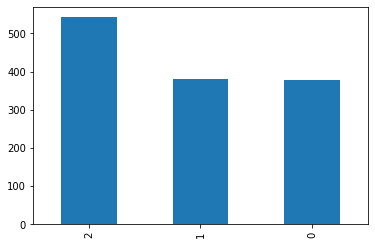

In [9]:
sourcetestdata_hybridoutput["hybrid_label"].value_counts().plot.bar()

<AxesSubplot:>

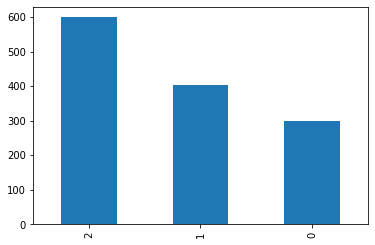

In [24]:
sourcetestdata_hybridoutput["real_labels"].value_counts().plot.bar()

<AxesSubplot:>

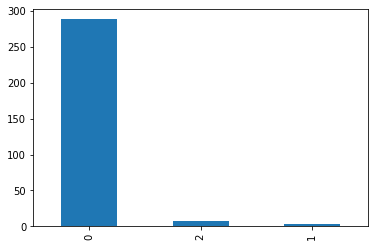

In [25]:
sourcetestdata_hybridoutput[sourcetestdata_hybridoutput["real_labels"]==0]["hybrid_label"].value_counts().plot.bar()

<AxesSubplot:>

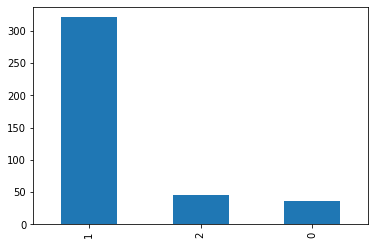

In [26]:
sourcetestdata_hybridoutput[sourcetestdata_hybridoutput["real_labels"]==1]["hybrid_label"].value_counts().plot.bar()

<AxesSubplot:>

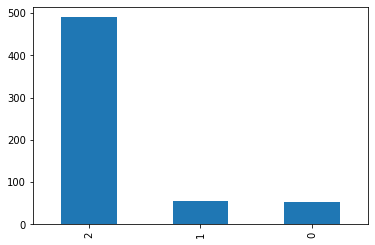

In [27]:
sourcetestdata_hybridoutput[sourcetestdata_hybridoutput["real_labels"]==2]["hybrid_label"].value_counts().plot.bar()

In [28]:
from sklearn.metrics import accuracy_score

accuracy_score(sourcetestdata_hybridoutput["real_labels"], sourcetestdata_hybridoutput["hybrid_label"])

0.8453846153846154

In [35]:
import ast 


(array([  3.,   3.,   4.,  12.,  12.,  21.,  21.,  18.,  24.,  20.,  22.,
         29.,  31.,  25.,  33.,  33.,  30.,  66.,  91., 802.]),
 array([0.34588388, 0.37858418, 0.41128449, 0.44398479, 0.47668509,
        0.5093854 , 0.5420857 , 0.57478601, 0.60748631, 0.64018662,
        0.67288692, 0.70558723, 0.73828753, 0.77098784, 0.80368814,
        0.83638845, 0.86908875, 0.90178906, 0.93448936, 0.96718967,
        0.99988997]),
 <BarContainer object of 20 artists>)

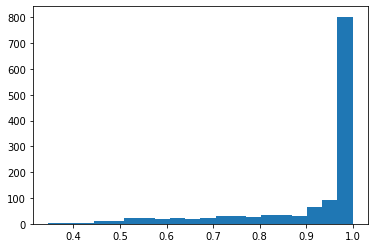

In [40]:
nn_probs = list(sourcetestdata_hybridoutput["hybrid_nn_probs"])
nn_probs = [ast.literal_eval(s) for s in nn_probs]
nn_max_probs = np.amax(np.array(nn_probs), axis = 1)
plt.hist(nn_max_probs, bins = 20)

(array([ 18.,  26.,  54.,  70., 128., 166., 158., 154., 163., 118.,  82.,
         52.,  49.,  27.,  13.,  10.,   3.,   6.,   1.,   2.]),
 array([0.33975089, 0.35071878, 0.36168667, 0.37265456, 0.38362245,
        0.39459033, 0.40555822, 0.41652611, 0.427494  , 0.43846189,
        0.44942978, 0.46039766, 0.47136555, 0.48233344, 0.49330133,
        0.50426922, 0.51523711, 0.52620499, 0.53717288, 0.54814077,
        0.55910866]),
 <BarContainer object of 20 artists>)

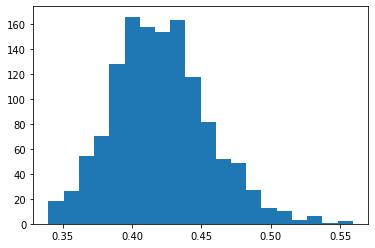

In [41]:
tfidf_probs = list(sourcetestdata_hybridoutput["hybrid_tfidf_probs"])
tfidf_probs = [ast.literal_eval(s) for s in tfidf_probs]
tfidf_max_probs = np.amax(np.array(tfidf_probs), axis = 1)
plt.hist(tfidf_max_probs, bins = 20)

In [42]:
articletestdata_hybridoutput = pd.read_csv("articletestdata_hybridoutput.csv")
articletestdata_hybridoutput.head()

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,...,isbiased,biascategories,bias_magnitude,bias_text,content,pred_labels,hybrid_label,hybrid_prob,hybrid_nn_probs,hybrid_tfidf_probs
0,2,http://www.washingtonpost.com/opinions/dont-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,david cole is a professor of constitutional la...,600,...,0,0,0.0,center,david cole is a professor of constitutional la...,1,1,0.998456,"[0.000621203682385385, 0.9984557628631592, 0.0...","[0.23367315624150653, 0.3188542931213096, 0.44..."
1,4,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,u.s. immigration citizenship and immigration s...,600,...,0,0,0.0,center,u.s. immigration citizenship and immigration s...,2,2,0.996456,"[0.00017927114095073193, 0.003364395350217819,...","[0.21772001107917457, 0.30858230910860185, 0.4..."
2,8,http://www.dailykos.com/story/2013/12/02/12595...,News,1,Civil Rights,Civil Rights,SomewhatPositive,SomewhatNegative,the following irresponsible police...,498,...,1,1,1.0,left,the following irresponsible police...,2,2,0.981165,"[0.00046024733455851674, 0.018374672159552574,...","[0.21621107872193918, 0.2931501517807278, 0.49..."
3,9,http://www.nytimes.com/2013/05/24/us/politics/...,News,1,Civil Rights,Civil Rights,Neutral,Neutral,an alternative possibility is that a bipartisa...,372,...,0,0,0.0,center,an alternative possibility is that a bipartisa...,1,1,0.998758,"[0.0005090124905109406, 0.9987584352493286, 0....","[0.18708066801123957, 0.3254286696422012, 0.48..."
4,11,http://www.latimes.com/news/local/la-me-cap-gu...,other,0,Civil Rights,Civil Rights,Neutral,SomewhatPositive,"sacramento — “living in parallel universes,” i...",600,...,1,-1,0.5,right,"sacramento — “living in parallel universes,” i...",1,1,0.536058,"[0.002071336144581437, 0.5360579490661621, 0.4...","[0.27190308227016163, 0.3106431771033703, 0.41..."


In [43]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# tokenizer_transformer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
test_labels = np.asarray(le.fit_transform(articletestdata_hybridoutput['bias_text']))

articletestdata_hybridoutput["real_labels"] =test_labels
articletestdata_hybridoutput

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,...,biascategories,bias_magnitude,bias_text,content,pred_labels,hybrid_label,hybrid_prob,hybrid_nn_probs,hybrid_tfidf_probs,real_labels
0,2,http://www.washingtonpost.com/opinions/dont-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,david cole is a professor of constitutional la...,600,...,0,0.0,center,david cole is a professor of constitutional la...,1,1,0.998456,"[0.000621203682385385, 0.9984557628631592, 0.0...","[0.23367315624150653, 0.3188542931213096, 0.44...",0
1,4,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,u.s. immigration citizenship and immigration s...,600,...,0,0.0,center,u.s. immigration citizenship and immigration s...,2,2,0.996456,"[0.00017927114095073193, 0.003364395350217819,...","[0.21772001107917457, 0.30858230910860185, 0.4...",0
2,8,http://www.dailykos.com/story/2013/12/02/12595...,News,1,Civil Rights,Civil Rights,SomewhatPositive,SomewhatNegative,the following irresponsible police...,498,...,1,1.0,left,the following irresponsible police...,2,2,0.981165,"[0.00046024733455851674, 0.018374672159552574,...","[0.21621107872193918, 0.2931501517807278, 0.49...",1
3,9,http://www.nytimes.com/2013/05/24/us/politics/...,News,1,Civil Rights,Civil Rights,Neutral,Neutral,an alternative possibility is that a bipartisa...,372,...,0,0.0,center,an alternative possibility is that a bipartisa...,1,1,0.998758,"[0.0005090124905109406, 0.9987584352493286, 0....","[0.18708066801123957, 0.3254286696422012, 0.48...",0
4,11,http://www.latimes.com/news/local/la-me-cap-gu...,other,0,Civil Rights,Civil Rights,Neutral,SomewhatPositive,"sacramento — “living in parallel universes,” i...",600,...,-1,0.5,right,"sacramento — “living in parallel universes,” i...",1,1,0.536058,"[0.002071336144581437, 0.5360579490661621, 0.4...","[0.27190308227016163, 0.3106431771033703, 0.41...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8345,12345,http://www.washingtonpost.com/opinions/dana-mi...,News,1,Republican Scandals,Republican Scandals,SomewhatPositive,SomewhatNegative,president obama won reelection in part by beat...,600,...,1,1.0,left,president obama won reelection in part by beat...,1,1,0.823416,"[0.002092322800308466, 0.8234157562255859, 0.1...","[0.21459188864785964, 0.31366076359960604, 0.4...",1
8346,12346,http://news.yahoo.com/republicans-hatred-obama...,Opinion,1,Republican Scandals,Republican Scandals,SomewhatPositive,SomewhatNegative,"red-faced republicans, circling and preparing ...",600,...,1,1.0,left,"red-faced republicans, circling and preparing ...",2,2,0.654309,"[0.0012914108810946345, 0.34439972043037415, 0...","[0.269000070425039, 0.34131314969312876, 0.389...",1
8347,12347,http://www.washingtonpost.com/opinions/dana-mi...,News,1,Republican Scandals,Republican Scandals,Neutral,Neutral,rep. steve stockman’s moment as a viable senat...,600,...,0,0.0,center,rep. steve stockman’s moment as a viable senat...,1,1,0.998007,"[0.0005887270090170205, 0.9980067610740662, 0....","[0.21888120446599127, 0.3412431901403461, 0.43...",0
8348,12348,http://www.washingtonpost.com/opinions/ej-dion...,News,1,Republican Scandals,Republican Scandals,SomewhatPositive,SomewhatNegative,we interrupt this highly partisan and ideologi...,600,...,1,1.0,left,we interrupt this highly partisan and ideologi...,1,1,0.897924,"[0.00846980232745409, 0.8979237079620361, 0.09...","[0.20641056282045653, 0.34472664869425257, 0.4...",1


<AxesSubplot:>

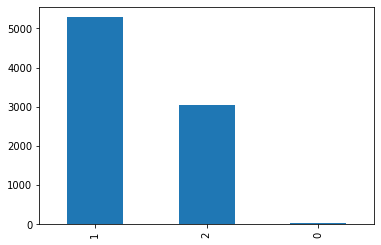

In [44]:
articletestdata_hybridoutput["hybrid_label"].value_counts().plot.bar()

<AxesSubplot:>

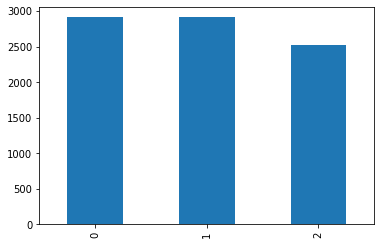

In [45]:
articletestdata_hybridoutput["real_labels"].value_counts().plot.bar()

<AxesSubplot:>

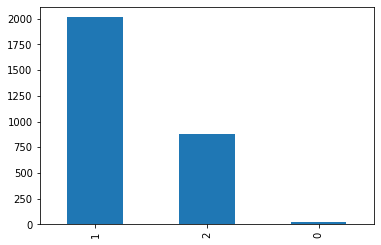

In [46]:
articletestdata_hybridoutput[articletestdata_hybridoutput["real_labels"]==0]["hybrid_label"].value_counts().plot.bar()

<AxesSubplot:>

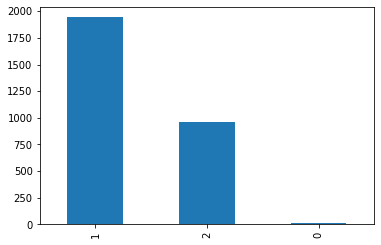

In [47]:
articletestdata_hybridoutput[articletestdata_hybridoutput["real_labels"]==1]["hybrid_label"].value_counts().plot.bar()

<AxesSubplot:>

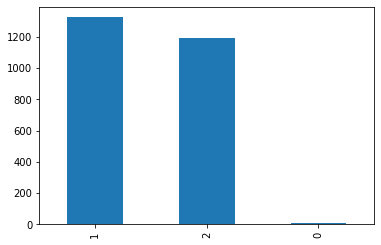

In [48]:
articletestdata_hybridoutput[articletestdata_hybridoutput["real_labels"]==2]["hybrid_label"].value_counts().plot.bar()

In [49]:
from sklearn.metrics import accuracy_score

accuracy_score(articletestdata_hybridoutput["real_labels"], articletestdata_hybridoutput["hybrid_label"])

0.37796407185628744

In [35]:
import ast 


(array([3.000e+00, 6.000e+00, 4.000e+00, 2.700e+01, 1.620e+02, 1.910e+02,
        2.090e+02, 1.820e+02, 2.020e+02, 1.990e+02, 2.720e+02, 2.380e+02,
        2.680e+02, 3.230e+02, 3.580e+02, 3.980e+02, 5.280e+02, 6.310e+02,
        1.092e+03, 3.057e+03]),
 array([0.36363831, 0.39544349, 0.42724868, 0.45905386, 0.49085904,
        0.52266423, 0.55446941, 0.58627459, 0.61807978, 0.64988496,
        0.68169014, 0.71349532, 0.74530051, 0.77710569, 0.80891087,
        0.84071606, 0.87252124, 0.90432642, 0.93613161, 0.96793679,
        0.99974197]),
 <BarContainer object of 20 artists>)

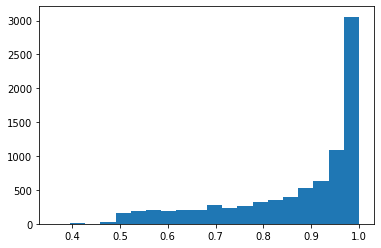

In [50]:
nn_probs = list(articletestdata_hybridoutput["hybrid_nn_probs"])
nn_probs = [ast.literal_eval(s) for s in nn_probs]
nn_max_probs = np.amax(np.array(nn_probs), axis = 1)
plt.hist(nn_max_probs, bins = 20)

(array([2.100e+01, 8.200e+01, 2.130e+02, 5.520e+02, 1.005e+03, 1.486e+03,
        1.592e+03, 1.373e+03, 1.010e+03, 5.780e+02, 2.430e+02, 1.110e+02,
        4.700e+01, 1.900e+01, 5.000e+00, 6.000e+00, 4.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00]),
 array([0.35046001, 0.36430655, 0.3781531 , 0.39199965, 0.40584619,
        0.41969274, 0.43353929, 0.44738584, 0.46123238, 0.47507893,
        0.48892548, 0.50277202, 0.51661857, 0.53046512, 0.54431166,
        0.55815821, 0.57200476, 0.58585131, 0.59969785, 0.6135444 ,
        0.62739095]),
 <BarContainer object of 20 artists>)

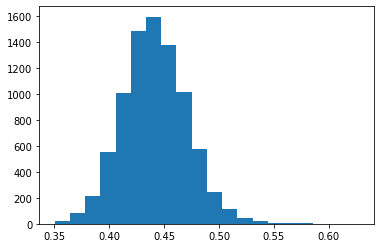

In [51]:
tfidf_probs = list(articletestdata_hybridoutput["hybrid_tfidf_probs"])
tfidf_probs = [ast.literal_eval(s) for s in tfidf_probs]
tfidf_max_probs = np.amax(np.array(tfidf_probs), axis = 1)
plt.hist(tfidf_max_probs, bins = 20)

<AxesSubplot:>

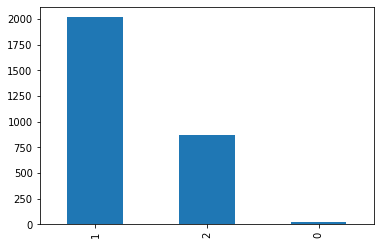

In [53]:
articletestdata_hybridoutput[articletestdata_hybridoutput["biaslabel"]=="Neutral"]["pred_labels"].value_counts().plot.bar()

<AxesSubplot:>

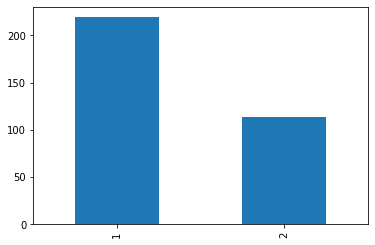

In [54]:
articletestdata_hybridoutput[articletestdata_hybridoutput["biaslabel"]=="Very Liberal"]["pred_labels"].value_counts().plot.bar()

<AxesSubplot:>

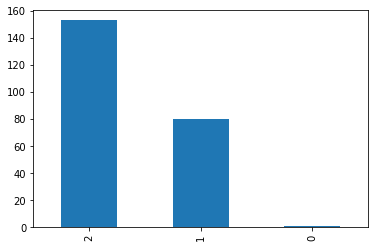

In [55]:
articletestdata_hybridoutput[articletestdata_hybridoutput["biaslabel"]=="Very Conservative"]["pred_labels"].value_counts().plot.bar()